In [ ]:
!pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai ragas tiktoken cohere faiss_cpu sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import langchain
print(f"LangChain Version: {langchain.__version__}")

LangChain Version: 0.1.14


Since we'll be using OpenAI to power our RAG pipeline and part of the functionality of the RAGAS library - we'll need an OpenAI API key!

In [ ]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

Please provide your OpenAI Key: ··········


In [ ]:
import string
from langchain.chains import ConversationalRetrievalChain
from sentence_transformers import SentenceTransformer, util
from langchain_community.embeddings import HuggingFaceEmbeddings # import hf embedding
from langchain_community.vectorstores import Chroma,FAISS
from langchain_community.llms import Ollama
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
import pandas as pd

from langchain import hub
from langchain_openai import OpenAIEmbeddings
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate


from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

from glob import glob

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/'DATA 298 Team 7'/Data/'Sonia Processed'/
%ls

/content/drive/Shareddrives/DATA 298 Team 7/Data/Sonia Processed
'298A Sonia Processed'/          'sonia eval'/              Untitled0.ipynb
 new_reddit_faiss_responses_db/   testing_summary.gsheet
 qlora_finetuning_data.pkl        travel_QA_processed.csv


In [ ]:
# reddit_3308_df = pd.read_csv("travel_QA_processed.csv")
# new_reddit = reddit_3308_df.copy()
# new_reddit.drop(['filename','id','source','combined', 'cause_clean', 'bert_summary'],axis=1,inplace=True)
# for i,r in new_reddit.iterrows():
#     clean_text = [c.translate(str.maketrans('', '', string.punctuation)).replace('\n','') for c in r['comments'].strip('][').split(', ')]
#     joined_text = ','.join(clean_text)
#     new_reddit.loc[i,'cleaned_comments'] = joined_text
# question_loader = DataFrameLoader(new_reddit, page_content_column="cleaned_comments")
# question_data = question_loader.load()

# splitter = RecursiveCharacterTextSplitter(chunk_size=400,
#                                           chunk_overlap=20)
# texts = splitter.split_documents(question_data)

In [ ]:
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
# db = FAISS.from_documents(texts, embedding_function)

# db.save_local("new_reddit_faiss_responses_db")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
retriever = FAISS.load_local("new_reddit_faiss_responses_db",
                      embedding_function,
                      allow_dangerous_deserialization=True).as_retriever()

In [ ]:

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [ ]:
query = "What are some fun things to do in san jose?"

In [ ]:
rr_model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')

In [ ]:
rag_contexts = retriever.invoke("What are some fun things to do in san jose?")

In [ ]:
candidate_matches = [d.metadata['selftext'] for d in rag_contexts if 'selftext' in d.metadata.keys()]

In [ ]:
candidate_matches

['Im a year old gay guy going to San Fransisco from April thth. Im leaving on the th so I wont have a whole lot of time to do things on that day though. Im trying to get tickets for a whale watching tour and a tour of Alcatraz. What other must see touristy things should I make sure I go to? Any good ones to go to for lgbtqia history that arent generally listed in online searches? Are there any great places to eat I should make sure not to miss nothing too pricey, Ive got enough money to travel but not enough to do it all fancy like. Although Im from NYC so my perception of what is or isnt pricey is usually blown away when I go other places but from what I understand that wont be the case in SF. As a gay fella obviously Id like to try and go to some gay bars during the night time in SF so any recommendations would be great. Im not big into loud flashy dance places. I prefer more chill lounge sorts of bars. Ideally somewhere with some sort of entertainment because that makes being alone 

In [ ]:
def reranker(query,retrievals, corr_field,thres=0.5):
    query_emb = rr_model.encode(query)
    doc_emb = rr_model.encode(corr_field)
    scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()
    doc_score_pairs = list(zip(retrievals, scores))
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    return ([(doc,score) for doc,score in doc_score_pairs if score>thres])

In [ ]:
reranked_contexts = reranker(query,rag_contexts,candidate_matches,0.33)
full_context = ' '.join([f[0].page_content for f in reranked_contexts])

In [ ]:
[f[0].page_content for f in reranked_contexts]

['work in your airbnb itself And the cafes in seoul are some of the best to work in in the world,Cant you monk mode just about anywhere I always thought it was more of a mindset,not a location,Monk mode can be done anywhere I did mine in the suburb of Palermo,Italy If you are not going to enjoy the facilities,you might as well find the cheapest place possible,East Asia has very quiet cities,If you',
 'chill atmosphere If I had a mo project to hunker down on,thats where Id go Excellent street markets each morning and night A lot of physical activity to do,and easy access to other areas as it has an airport and a high speed train connecting it to the outside world,I did my monk mode in a tiny town in Maine for a year though wouldnt recommend it haha Now that Im in Puerto Rico,Id pick somewhere',
 'quiet cities,If you like the waterswimming,a smallish coastal city might do you good Nayarit and Puerto Escondido were quite lovely and its probably a good time to go from now until early summe

In [ ]:

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

In [ ]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple - but we'll create our own to be a bit more specific!

In [ ]:

template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
primary_qa_llm = ChatOpenAI(model_name="gpt-4-32k-0613", temperature=0)


In [ ]:


retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

Let's create a new set of documents to ensure we're not accidentally creating a sample test set that favours our base model too much!

In [ ]:
%cd /content/drive/Shareddrives/DATA 298 Team 7/Data/"Chris' Sandbox"/
%ls

/content/drive/Shareddrives/DATA 298 Team 7/Data/Chris' Sandbox
 Curating_datasets.ipynb                mistral_CRC_ragas_eval.csv
 databricks-dolly-15k_travel.pkl        mistral_RR_ragas.csv
'Fine Tuning LLMs Documentation.gdoc'   mistral_RR_ragas_eval.csv
 fine_tuning_wanderchat.ipynb           MPC_ragas.csv
 golden_answers.csv                     MPC_ragas_eval.csv
 llama2_298a_ragas.csv                  pre_trained_llama2_ragas.csv
 llama2_298a_ragas_eval.csv             pre_trained_llama2_ragas_eval.csv
 llama2_CRC_ragas.csv                   pre_trained_mistral_ragas.csv
 llama2_CRC_ragas_eval.csv              pre_trained_mistral_ragas_eval.csv
 llama2_RAFT_ragas.csv                  ragas_advanced_retrieval_results.csv
 llama2_RAFT_ragas_eval.csv             ragas_baseline.csv
 llama2_RR_ragas.csv                    ragas_merged_baseline_multi.csv
 llama2_RR_ragas_eval.csv               ragas_reranker.csv
 mistral_CRC_ragas.csv


In [ ]:
test_df = pd.read_csv("golden_answers.csv",skiprows=1)\
        .rename(columns={'Golden Question':'question',
                         'Golden Answer - SM':'ground_truth',
                         'Unnamed: 3':'response'})[['question','ground_truth']]
test_df['question'] = test_df['question'].apply(lambda x:x.replace('\n',''))
test_df

,question,ground_truth
0,What are your favorite luxury camp meals for a...,It sounds like a fantastic trip you have plann...
1,I'm taking a solo trip with my dog around Than...,Planning a solo road trip with your dog around...
2,I'm planning a 3-4 week family road trip from ...,Embarking on a cross-Canada road trip with you...
3,What are the main differences between visiting...,If you're choosing between Seoul and Tokyo for...
4,Seeking destination and activity suggestions f...,Planning a short solo trip for your birthday i...
5,"Where's the best place to go ""monk mode"" for t...","For a focused ""monk mode"" retreat, you'll want..."
6,I'm a 28-year-old male heading to Guangzhou fo...,Guangzhou is a vibrant city with a rich blend ...
7,Is Ho Chi Minh safe for a girl's solo trip?,"Ho Chi Minh City, commonly referred to as Saig..."
8,I'm considering booking a trip through Costco...,Costco Travel packages offer a convenient way ...
9,I'm planning a two-month trip to Europe in Ma...,If you're heading to Europe for a few months a...


In [ ]:
from glob import glob
cv_test_dfs = glob('./*_ragas.csv')
cv_test_dfs

['./llama2_CRC_ragas.csv',
 './mistral_CRC_ragas.csv',
 './llama2_RR_ragas.csv',
 './mistral_RR_ragas.csv',
 './MPC_ragas.csv',
 './llama2_298a_ragas.csv',
 './llama2_RAFT_ragas.csv',
 './pre_trained_llama2_ragas.csv',
 './pre_trained_mistral_ragas.csv']

In [ ]:
already_completed = ['./llama2_CRC_ragas.csv',
 './mistral_CRC_ragas.csv',
 './llama2_RR_ragas.csv',
 './mistral_RR_ragas.csv',
 './MPC_ragas.csv',
 './llama2_298a_ragas.csv']

In [ ]:
remaining = [f for f in cv_test_dfs if f not in already_completed]
remaining

['./pre_trained_mistral_ragas.csv',
 './llama2_RAFT_ragas.csv',
 './pre_trained_llama2_ragas.csv']

In [ ]:
def find_first_float(lst):
    for item in lst:
        if isinstance(item, float):
            return item
    return None

In [ ]:
for r in ['./llama2_RAFT_ragas.csv']:
  fname = r.split('/')[1].split('.')[0]
  print(fname)
  df = pd.read_csv(r,index_col='Unnamed: 0').drop_duplicates()

  #display(df)

  #display(df.iloc[4]['question'])
  #display(test_df.iloc[6]['question'])

  merged = pd.merge(df, test_df,on="question").drop_duplicates()

  #display(merged)

  merged.loc[4,'answer'] = "I'm a 28-year-old male heading to Guangzhou for the first time this December for a three-week stay. Without Mandarin or Cantonese skills, I'm looking for advice on engaging activities and places to explore. My interests include spas, nightlife, good food, video games,"

  data_dict = {
      "question" : merged["question"].values.tolist(),
      "answer" : merged["answer"].values.tolist(),
      "contexts" : [c.split('-') for c in merged["contexts"].values],
      "ground_truth" : merged["ground_truth"].values.tolist()
    }

  response_dataset = Dataset.from_dict(data_dict)

  print('evaluating...')
  results = evaluate(response_dataset, metrics,llm=ChatOpenAI(model_name="gpt-4-turbo-preview"))
  results_df = results.to_pandas()
  print('Completed. writing...')
  results_df.to_csv(f"{fname}_eval.csv")


llama2_RAFT_ragas
evaluating...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Completed. writing...


In [ ]:
for r in ['./pre_trained_llama2_ragas.csv']:
  fname = r.split('/')[1].split('.')[0]
  print(fname)
  df = pd.read_csv(r,index_col='Unnamed: 0').drop_duplicates()
  merged = pd.merge(df, test_df,on="question").drop_duplicates()

  response_dataset = Dataset.from_dict({
    "question" : merged["question"].values.tolist(),
    "answer" : merged["answer"].values.tolist(),
    "contexts" : [c.split('-') for c in merged["contexts"].values],
    "ground_truth" : merged["ground_truth"].values.tolist()
  })
  print('evaluating...')
  results = evaluate(response_dataset, metrics,llm=ChatOpenAI(model_name="gpt-4-turbo-preview"))
  results_df = results.to_pandas()
  print('Completed. writing...')
  results_df.to_csv(f"{fname}_eval.csv")


pre_trained_llama2_ragas
evaluating...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Completed. writing...


In [ ]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

In [ ]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(
        content="You are a helpful assistant that translates English to French."
    ),
    HumanMessage(
        content="Translate this sentence from English to French. I love programming."
    ),
]
primary_qa_llm.invoke(messages).content

"J'adore programmer."

In [ ]:
rr_answers,rr_contexts = [],[]
for question in test_questions:
  rag_contexts = retriever.invoke(question)
  candidate_matches = [d.metadata['selftext'] for d in rag_contexts if 'selftext' in d.metadata.keys()]
  reranked_contexts = reranker(question,rag_contexts,candidate_matches,0.33)
  rr_contexts.append([f[0].page_content for f in reranked_contexts])
  rr_context_str = ' '.join([f[0].page_content for f in reranked_contexts])
  messages = [
    SystemMessage(
        content="""If context is empty, say "I don't know. Please give me more context". Answer the query using the information in the documents provided in the context.
    If the information is not available in the context or the document is empty or is irrelevant to the query, say so. Do not make up information.
    Explain in which document you found the information. Do not repeat the question and context, or explicity refer to the context, explain as if you're speaking to a
    clueless traveler. """
    ),
    HumanMessage(
        content=f"Query: {question}, Context: {rr_context_str}"
    ),
  ]
  rr_answers.append(primary_qa_llm.invoke(messages).content)

#### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [ ]:


# response_dataset = Dataset.from_dict({
#     "question" : test_questions,
#     "answer" : answers,
#     "contexts" : contexts,
#     "ground_truth" : test_groundtruths
# })

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : rr_answers,
    "contexts" : rr_contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [ ]:
response_dataset[0]

{'question': "What are your favorite luxury camp meals for a beginner-friendly 10-mile, 3-day backpacking trip, considering I'm willing to carry 10lbs of food and have basic cookware?",
 'answer': "I found some great luxury camp meal ideas for a beginner-friendly 3-day backpacking trip in the document provided. For a 10-mile hike, you could consider preparing and carrying freeze-dried steaks or burgers for the first night. For the other nights, a good option could be Velveeta shells and cheddar mac and cheese. Another suggestion is to make cheese steaks using beef jerky if you're willing to carry buns. For a more luxurious meal, you could season and grill chicken or steak ahead of time, slice it, and vacuum seal it or pack it into a freezer bag. You can also pack chopped raw onions and peppers, oil or butter, shredded cheese, hot sauce, and flour tortillas to make delicious campfire fajitas. These meals are not too bulky, heavy, or labor-intensive and can be cooked over a fire or stove

#### Evaluating with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

All that's left to do is call "evaluate" and away we go!

In [ ]:
results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
results

{'faithfulness': 0.9156, 'answer_relevancy': 0.7268, 'context_recall': 0.3379, 'context_precision': 0.9924, 'answer_correctness': 0.5959}

In [ ]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What are your favorite luxury camp meals for a...,I found some great luxury camp meal ideas for ...,[weight options Also dont forget coffeeteahot ...,It sounds like a fantastic trip you have plann...,1.000000,0.912507,0.000000,0.916667,0.512974
1,I'm taking a solo trip with my dog around Than...,Based on the information provided in the docum...,"[online and look at pictures,Eat at Tin Can Al...",Planning a solo road trip with your dog around...,0.875000,0.864797,0.000000,1.000000,0.535248
2,I'm planning a 3-4 week family road trip from ...,I found some recommendations for your road tri...,[Quebec part after Main Beauce region Driving ...,Embarking on a cross-Canada road trip with you...,1.000000,0.890519,0.000000,1.000000,0.669959
3,What are the main differences between visiting...,"Based on the personal experiences shared, ther...","[are open much later,including shops,restauran...",If you're choosing between Seoul and Tokyo for...,0.714286,0.930548,0.714286,1.000000,0.650003
4,Seeking destination and activity suggestions f...,For your first solo trip over your birthday we...,[but you can go to Traverse City or the UP Lot...,Planning a short solo trip for your birthday i...,1.000000,0.868705,0.166667,1.000000,0.565166
5,"Where's the best place to go ""monk mode"" for t...",I found some suggestions for places where you ...,[work in your airbnb itself And the cafes in s...,"For a focused ""monk mode"" retreat, you'll want...",1.000000,0.908388,1.000000,1.000000,0.592437
6,I'm a 28-year-old male heading to Guangzhou fo...,"In Guangzhou, there are several activities and...","[Guangzhou parks are great,plus theres a lot o...",Guangzhou is a vibrant city with a rich blend ...,0.818182,0.872589,1.000000,1.000000,0.671870
7,Is Ho Chi Minh safe for a girl's solo trip?,I don't know. Please give me more context.,[Pretty much all of Hanoi is safe As far as th...,"Ho Chi Minh City, commonly referred to as Saig...",NaN,0.000000,0.076923,1.000000,0.922006
8,I'm considering booking a trip through Costco...,"In the provided information, travelers have sh...","[We used them for a Europe trip,tour was booke...",Costco Travel packages offer a convenient way ...,1.000000,0.892881,0.571429,1.000000,0.694553
9,I'm planning a two-month trip to Europe in Ma...,I don't know. Please give me more context.,"[really read your criteria,but these are some ...",If you're heading to Europe for a few months a...,NaN,0.000000,0.187500,1.000000,0.174161


In [ ]:
results_df.to_csv("ragas_reranker.csv")

## Testing a More Performant Retriever

Now that we have established a baseline - we can see how any changes impact our pipeline's performance!

Let's modify our retriever and see how that impacts our Ragas metrics!

In [ ]:
from langchain.retrievers import MultiQueryRetriever

advanced_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=primary_qa_llm)

We'll also re-create our RAG pipeline using the abstractions that come packaged with LangChain v0.1.0!

First, let's create a chain to "stuff" our documents into our context!

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

Next, we'll create the retrieval chain!

In [ ]:
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(advanced_retriever, document_chain)

In [ ]:
response = retrieval_chain.invoke({"input": "What are some fun activites in the bay area?"})

In [ ]:
print(response["answer"])

Some fun activities in the Bay Area include visiting Muir Woods, checking out SF Funcheap for events, exploring Belly Good Cafe and Crepes in Japantown, stopping by Bay Beach amusement park, taking a ferry across the bay, visiting Embarcadero, exploring Golden Gate Park, and possibly checking out the Academy of Sciences.


Well, just from those responses this chain *feels* better - but lets see how it performs on our eval!

Let's do the same process we did before to collect our pipeline's contexts and answers.

In [ ]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

Now we can convert this into a dataset, just like we did before.

In [ ]:
response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's evaluate on the same metrics we did for the first pipeline and see how it does!

In [ ]:
advanced_retrieval_results = evaluate(response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

### Comparing Results

Now we can compare our results and see what directional changes occured!

Let's refresh with our initial metrics.

In [ ]:
results

{'faithfulness': 0.8810, 'answer_relevancy': 0.5665, 'context_recall': 0.4416, 'context_precision': 0.9823, 'answer_correctness': 0.4168}

And see how our advanced retrieval modified our chain!

In [ ]:
advanced_retrieval_results

{'faithfulness': 0.9842, 'answer_relevancy': 0.9027, 'context_recall': 0.3023, 'context_precision': 0.9669, 'answer_correctness': 0.6032}

In [ ]:
advanced_retrieval_results_df = advanced_retrieval_results.to_pandas()
advanced_retrieval_results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What are your favorite luxury camp meals for a...,"For a beginner-friendly 10-mile, 3-day backpac...",[weight options Also dont forget coffeeteahot ...,It sounds like a fantastic trip you have plann...,1.000000,0.968935,0.000000,1.00000,0.404664
1,I'm taking a solo trip with my dog around Than...,It seems like you have a well-planned trip wit...,"[the dog,since they arent allowed on trails sa...",Planning a solo road trip with your dog around...,0.916667,0.869165,0.000000,1.00000,0.640466
2,I'm planning a 3-4 week family road trip from ...,It sounds like you have an exciting road trip ...,"[Canadas really big Like,really big No,you can...",Embarking on a cross-Canada road trip with you...,1.000000,0.887182,0.058824,1.00000,0.650342
3,What are the main differences between visiting...,"Based on the context provided, the main differ...","[are open much later,including shops,restauran...",If you're choosing between Seoul and Tokyo for...,0.909091,0.930548,0.625000,1.00000,0.741263
4,Seeking destination and activity suggestions f...,Based on your preferences and location in Kala...,[more I want you to ditch your friends and jus...,Planning a short solo trip for your birthday i...,1.000000,0.894175,0.333333,0.81000,0.349045
5,"Where's the best place to go ""monk mode"" for t...","Based on the context provided, Luang Prabang i...","[quiet cities,If you like the waterswimming,a ...","For a focused ""monk mode"" retreat, you'll want...",1.000000,0.883832,0.230769,1.00000,0.621559
6,I'm a 28-year-old male heading to Guangzhou fo...,Based on your interests and the context provid...,"[Guangzhou parks are great,plus theres a lot o...",Guangzhou is a vibrant city with a rich blend ...,1.000000,0.874719,1.000000,1.00000,0.552040
7,Is Ho Chi Minh safe for a girl's solo trip?,"Based on the context provided, Ho Chi Minh Cit...",[is great for disappearing for six months Chia...,"Ho Chi Minh City, commonly referred to as Saig...",1.000000,0.963962,0.076923,1.00000,0.850175
8,I'm considering booking a trip through Costco...,"Based on the context provided, individuals hav...","[We used them for a Europe trip,tour was booke...",Costco Travel packages offer a convenient way ...,1.000000,0.895025,0.500000,1.00000,0.731583
9,I'm planning a two-month trip to Europe in Ma...,For hidden gems in Europe that are beyond the ...,"[really read your criteria,but these are some ...",If you're heading to Europe for a few months a...,1.000000,0.860764,0.500000,0.82602,0.457666


In [ ]:
advanced_retrieval_results_df.to_csv("ragas_advanced_retrieval_results.csv")

In [ ]:

df_original = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'MultiQueryRetriever with Document Stuffing'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever with Document Stuffing'] - df_merged['Baseline']

df_merged

,Metric,Baseline,MultiQueryRetriever with Document Stuffing,Delta
0,faithfulness,0.880952,0.984160,0.103207
1,answer_relevancy,0.566471,0.902716,0.336246
2,context_recall,0.441613,0.302259,-0.139354
3,context_precision,0.982323,0.966911,-0.015412
4,answer_correctness,0.416756,0.603223,0.186467


In [ ]:
df_merged.to_csv("ragas_merged_baseline_multi.csv")

Merge RAG variants from default, MultiQueryRetriever, and Reranker

In [ ]:
glob('./*_ragas_eval.csv')

['./llama2_CRC_ragas_eval.csv',
 './MPC_ragas_eval.csv',
 './mistral_RR_ragas_eval.csv',
 './llama2_RR_ragas_eval.csv',
 './llama2_298a_ragas_eval.csv',
 './mistral_CRC_ragas_eval.csv',
 './pre_trained_mistral_ragas_eval.csv',
 './llama2_RAFT_ragas_eval.csv',
 './pre_trained_llama2_ragas_eval.csv']

In [ ]:
result_default = pd.read_csv("ragas_baseline.csv")
result_reranker = pd.read_csv("ragas_reranker.csv")
result_advanced = pd.read_csv("ragas_advanced_retrieval_results.csv")


In [ ]:
def collect_res(df):
  return [df['faithfulness'].mean(),df['answer_relevancy'].mean(),df['context_recall'].mean(),df['context_precision'].mean(),df['answer_correctness'].mean()]

def percent_change(original_value, new_value):
    change = round(((original_value - new_value) / new_value) * 100,2)
    # Check if the change is positive or negative and format accordingly
    return f"+ {change}%" if change > 0 else f"{change}%"

In [ ]:
final = pd.DataFrame({'Metric':['faithfulness', 'answer_relevancy', 'context_recall','context_precision', 'answer_correctness']})
final['OAI_baseline'] = collect_res(result_default)
final['OAI_Reranker'] = collect_res(result_reranker)
final['OAI_MultiQueryRetriever with Document Stuffing'] = collect_res(result_advanced)
# final['baseline_vs_reranker'] = final.apply(lambda x: percent_change(x['Reranker'],x['baseline']), axis=1)
# final['baseline_vs_multi'] = final.apply(lambda x: percent_change(x['MultiQueryRetriever with Document Stuffing'],x['baseline']), axis=1)
# final['reranker_vs_multi'] = final.apply(lambda x: percent_change(x['MultiQueryRetriever with Document Stuffing'],x['Reranker']), axis=1)

for e in glob('./*_ragas_eval.csv'):
  temp = pd.read_csv(e)
  fname = e.split('/')[1].split('.')[0].replace('_ragas_eval','')
  final[fname] = collect_res(temp)

final.columns

Index(['Metric', 'OAI_baseline', 'OAI_Reranker',
       'OAI_MultiQueryRetriever with Document Stuffing', 'llama2_CRC', 'MPC',
       'mistral_RR', 'llama2_RR', 'llama2_298a', 'mistral_CRC',
       'pre_trained_mistral', 'llama2_RAFT', 'pre_trained_llama2'],
      dtype='object')

In [ ]:
final.to_csv("qual_metrics_all_LLMS.csv")

In [ ]:
df_melted = final.melt(id_vars=['Metric'],
                            value_vars=['OAI_baseline', 'OAI_Reranker',
       'OAI_MultiQueryRetriever with Document Stuffing', 'llama2_CRC', 'MPC',
       'mistral_RR', 'llama2_RR', 'llama2_298a', 'mistral_CRC',
       'pre_trained_mistral', 'llama2_RAFT', 'pre_trained_llama2'])
df_melted

,Metric,variable,value
0,faithfulness,OAI_baseline,0.880952
1,answer_relevancy,OAI_baseline,0.566471
2,context_recall,OAI_baseline,0.441613
3,context_precision,OAI_baseline,0.982323
4,answer_correctness,OAI_baseline,0.416756
5,faithfulness,OAI_Reranker,0.915645
6,answer_relevancy,OAI_Reranker,0.726770
7,context_recall,OAI_Reranker,0.337891
8,context_precision,OAI_Reranker,0.992424
9,answer_correctness,OAI_Reranker,0.595879


<ipython-input-89-e479104b0c86>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_melted, x='value', y='Metric', inner='stick', palette='Dark2')


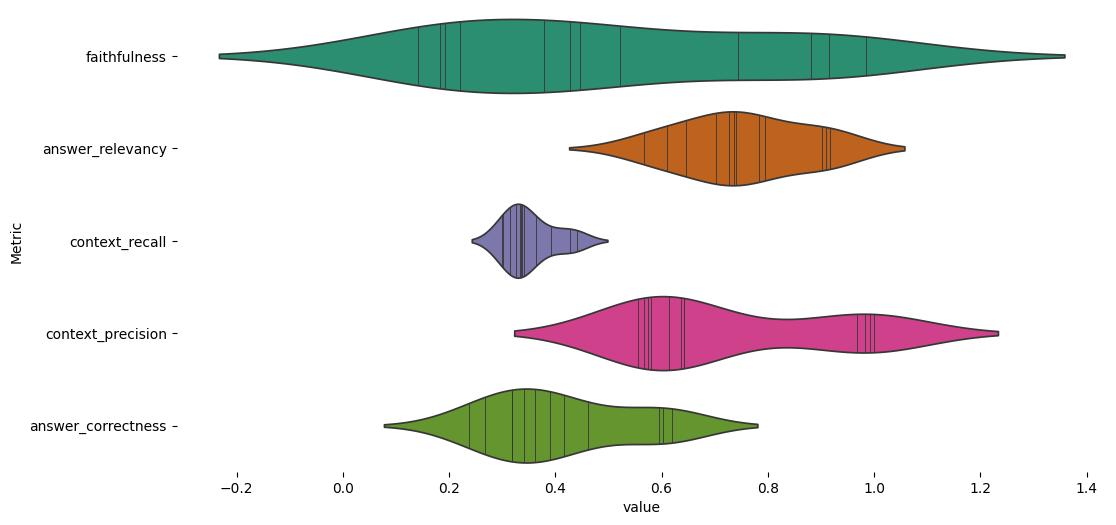

In [ ]:
# @title Metric vs value
figsize = (12, 1.2 * len(df_melted['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_melted, x='value', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

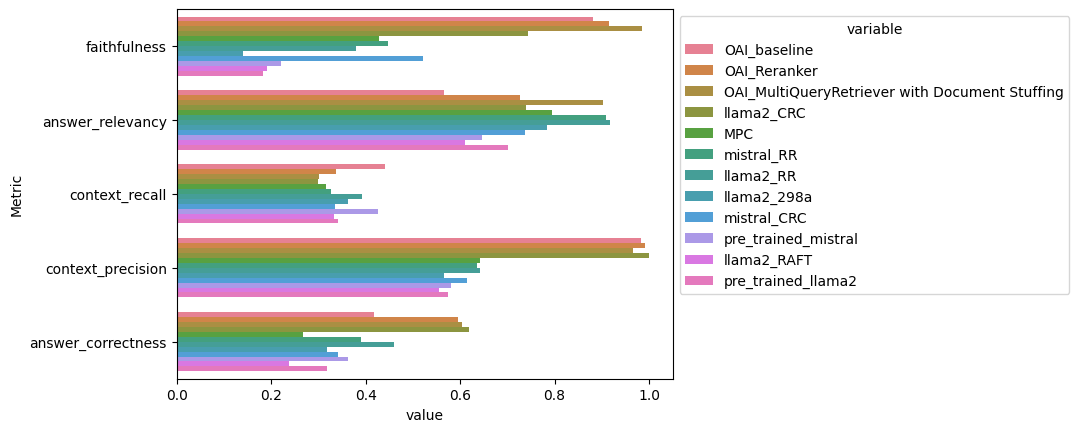

In [ ]:
ax = sns.barplot(data = df_melted,y='Metric',x='value',hue='variable',err_kws={'linewidth': 1})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# for i in ax.containers:
#     ax.bar_label(i,)


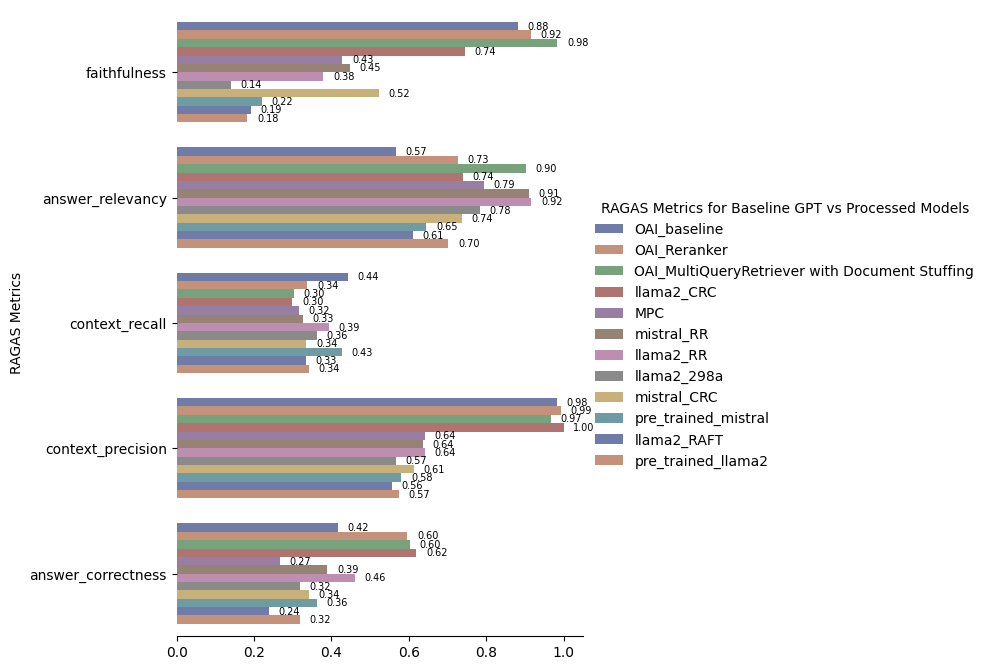

In [ ]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_melted, kind="bar",
    x="value", y="Metric", hue="variable",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
g.despine(left=True)
g.set_axis_labels("", "RAGAS Metrics")
g.legend.set_title("RAGAS Metrics for Baseline GPT vs Processed Models")

# auto-label bars
for container in g.ax.containers:
    g.ax.bar_label(container, fmt='%.2f', padding=7,fontsize=7)



In [ ]:
quant_df = pd.read_csv('./quant_metrics_all_LLMS.csv',index_col='Unnamed: 0')
quant_df.index = quant_df.index.set_names(['Metric'])
quant_df = quant_df.reset_index()
quant_df['OAI_baseline'] = np.nan
quant_df['OAI_Reranker'] = np.nan
quant_df['OAI_MultiQueryRetriever with Document Stuffing'] = np.nan
quant_df['mistral_RAFT'] = np.nan
quant_df.columns

Index(['Metric', 'MPC', 'llama2_298a', 'llama2_CRC', 'llama2_RAFT',
       'llama2_RR', 'mistral_CRC', 'mistral_RR', 'pre_trained_llama2',
       'pre_trained_mistral', 'OAI_baseline', 'OAI_Reranker',
       'OAI_MultiQueryRetriever with Document Stuffing', 'mistral_RAFT'],
      dtype='object')

In [ ]:
all_models = ['Metric','OAI_baseline', 'OAI_Reranker','OAI_MultiQueryRetriever with Document Stuffing','MPC','pre_trained_llama2','llama2_RAFT','llama2_CRC','llama2_RR','pre_trained_mistral','mistral_RAFT','mistral_CRC', 'mistral_RR']

In [ ]:
final['mistral_RAFT'] = np.nan
final.columns

Index(['Metric', 'OAI_baseline', 'OAI_Reranker',
       'OAI_MultiQueryRetriever with Document Stuffing', 'llama2_CRC', 'MPC',
       'mistral_RR', 'llama2_RR', 'llama2_298a', 'mistral_CRC',
       'pre_trained_mistral', 'llama2_RAFT', 'pre_trained_llama2',
       'mistral_RAFT'],
      dtype='object')

In [ ]:
output_table = pd.concat([quant_df[all_models],final[all_models]],axis=0).set_index('Metric')
output_table

,OAI_baseline,OAI_Reranker,OAI_MultiQueryRetriever with Document Stuffing,MPC,pre_trained_llama2,llama2_RAFT,llama2_CRC,llama2_RR,pre_trained_mistral,mistral_RAFT,mistral_CRC,mistral_RR
Metric,,,,,,,,,,,,
dot,NaN,NaN,NaN,0.731060,0.590338,0.444274,0.772202,0.860318,0.749673,NaN,0.774997,0.838217
embed_dist,NaN,NaN,NaN,0.105643,0.122163,0.179780,0.083572,0.072712,0.092046,NaN,0.089724,0.076998
faithfulness,0.880952,0.915645,0.984160,0.428333,0.182639,0.191667,0.744585,0.378642,0.220106,NaN,0.521919,0.446959
answer_relevancy,0.566471,0.726770,0.902716,0.794346,0.701826,0.610624,0.739491,0.916370,0.645676,NaN,0.737118,0.909717
context_recall,0.441613,0.337891,0.302259,0.315340,0.341547,0.333681,0.299128,0.392674,0.426816,NaN,0.335379,0.326098
context_precision,0.982323,0.992424,0.966911,0.641667,0.575000,0.555556,1.000000,0.641414,0.580556,NaN,0.613636,0.636364
answer_correctness,0.416756,0.595879,0.603223,0.266835,0.318101,0.238465,0.619217,0.460824,0.362611,NaN,0.341365,0.389341


In [ ]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
cm = sns.light_palette("green", as_cmap=True)
output_table.T.style.apply(highlight_max)

Metric,dot,embed_dist,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
OAI_baseline,nan,nan,0.880952,0.566471,0.441613,0.982323,0.416756
OAI_Reranker,nan,nan,0.915645,0.726770,0.337891,0.992424,0.595879
OAI_MultiQueryRetriever with Document Stuffing,nan,nan,0.984160,0.902716,0.302259,0.966911,0.603223
MPC,0.731060,0.105643,0.428333,0.794346,0.315340,0.641667,0.266835
pre_trained_llama2,0.590338,0.122163,0.182639,0.701826,0.341547,0.575000,0.318101
llama2_RAFT,0.444274,0.179780,0.191667,0.610624,0.333681,0.555556,0.238465
llama2_CRC,0.772202,0.083572,0.744585,0.739491,0.299128,1.000000,0.619217
llama2_RR,0.860318,0.072712,0.378642,0.916370,0.392674,0.641414,0.460824
pre_trained_mistral,0.749673,0.092046,0.220106,0.645676,0.426816,0.580556,0.362611
mistral_RAFT,nan,nan,nan,nan,nan,nan,nan


In [ ]:
%cd /content/drive/Shareddrives/DATA 298 Team 7/Data/"Chris' Sandbox"/
%ls

/content/drive/Shareddrives/DATA 298 Team 7/Data/Chris' Sandbox
'Another copy of Art of RAG Evaluation - LangChain & Ragas.ipynb'
 Curating_datasets.ipynb
 databricks-dolly-15k_travel.pkl
'Fine Tuning LLMs Documentation.gdoc'
 fine_tuning_wanderchat.ipynb
 followups.csv
 golden_answers.csv
 llama2_298a_ragas.csv
 llama2_298a_ragas_eval.csv
 llama2_CRC_ragas.csv
 llama2_CRC_ragas_eval.csv
 llama2_RAFT_ragas.csv
 llama2_RAFT_ragas_eval.csv
 llama2_RR_ragas.csv
 llama2_RR_ragas_eval.csv
 mistral_CRC_ragas.csv
 mistral_CRC_ragas_eval.csv
 mistral_RR_ragas.csv
 mistral_RR_ragas_eval.csv
 MPC_ragas.csv
 MPC_ragas_eval.csv
 pre_trained_llama2_ragas.csv
 pre_trained_llama2_ragas_eval.csv
 pre_trained_mistral_ragas.csv
 pre_trained_mistral_ragas_eval.csv
 qual_metrics_all_LLMS.csv
 quant_metrics_all_LLMS.csv
 ragas_advanced_retrieval_results.csv
 ragas_baseline.csv
 ragas_merged_baseline_multi.csv
 ragas_reranker.csv


In [ ]:
followups = pd.read_csv('followups.csv',index_col="Unnamed: 0")
followups_eval = followups.copy()
followups_eval['reranker_if'] = np.where(followups_eval['reranker'] != 'False','True',followups_eval['reranker'])

In [ ]:
from langchain_community.chat_models import ChatOpenAI
from langchain.evaluation.criteria import LabeledCriteriaEvalChain
from langchain.evaluation.scoring import ScoreStringEvalChain
from langchain.evaluation import Criteria
from langchain.evaluation import load_evaluator
from langchain.evaluation import EvaluatorType

llm = ChatOpenAI(model="gpt-4", temperature=0)

# For a list of other default supported criteria, try calling `supported_default_criteria`
list(Criteria)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


[<Criteria.CONCISENESS: 'conciseness'>,
 <Criteria.RELEVANCE: 'relevance'>,
 <Criteria.CORRECTNESS: 'correctness'>,
 <Criteria.COHERENCE: 'coherence'>,
 <Criteria.HARMFULNESS: 'harmfulness'>,
 <Criteria.MALICIOUSNESS: 'maliciousness'>,
 <Criteria.HELPFULNESS: 'helpfulness'>,
 <Criteria.CONTROVERSIALITY: 'controversiality'>,
 <Criteria.MISOGYNY: 'misogyny'>,
 <Criteria.CRIMINALITY: 'criminality'>,
 <Criteria.INSENSITIVITY: 'insensitivity'>,
 <Criteria.DEPTH: 'depth'>,
 <Criteria.CREATIVITY: 'creativity'>,
 <Criteria.DETAIL: 'detail'>]

In [ ]:
#example
criteria = "correctness"
evaluator = LabeledCriteriaEvalChain.from_llm(
    llm=llm,
     criteria=criteria, )
evaluator.evaluate_strings(
 prediction="The answer is 4",
 input="How many apples are there?",
 reference="There are 3 apples",
 )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


{'reasoning': 'The criterion for this task is the correctness of the submission. This means the submitted answer should be accurate and factual.\n\nThe input question is "How many apples are there?" and the submitted answer is "The answer is 4".\n\nThe reference answer, which is considered the correct answer, states "There are 3 apples".\n\nComparing the submitted answer with the reference answer, it is clear that the submitted answer is not correct. The submission states there are 4 apples, while the reference answer states there are 3 apples.\n\nTherefore, the submission does not meet the criterion of correctness.\n\nN',
 'value': 'N',
 'score': 0}

In [ ]:
custom_criterion = {
    "my-custom-criterion": """
    Is the response logically structured, relevant, accurate, and practically helpful
    information tailored to a wide range of travel-related queries, encompassing accommodation,
    transportation, itinerary planning, culinary experiences, and emergency situations? If the response mentions "I don't know" then give a score of 1 for admitting uncertainty.
    """
}

eval_chain = load_evaluator(
    EvaluatorType.CRITERIA,
    criteria=custom_criterion,
)
query = "tell me more about Gyeongbokgung Palace. why do tourists like to visit here and what are some surrounding must-dos?"
prediction = """ Gyeongbokgung Palace is a must-visit attraction in Seoul, South Korea. This historic palace compound was established in 1395 and served as the main royal palace for five Joseon dynasty kings. Tourists are drawn to its rich history and impressive architecture.Some reasons why visitors love Gyeongbokgung Palace include:1. Cultural Significance: Gyeongbokgung Palace is a symbol of Korean history and identity. It represents the country's strong cultural heritage and offers insights into traditional Korean customs and traditions.2. Beautiful Architecture: The palace grounds feature numerous impressive buildings, including Geunjeongjeon Hall (the main throne hall), Gyeonggamjeon Shrine, and Hyangwonjeong Pavilion. These structures are adorned with intricate designs, bright colors, and ornate details, making for stunning photo opportunities.3. Surrounding Must-Dos: There are several other attractions nearby that are worth visiting when you're in the area. Some popular options include:   * Changdeokgung Palace: Another historic palace compound located just south of Gyeongbokgung Palace, known for its more natural surroundings and relaxing atmosphere.   * Bukchon Hanok Village: A picturesque neighborhood filled with traditional Korean houses (hanoks) that offer a glimpse into the past.   * Namsan Tower: A modern landmark located on Namsan Mountain, offering panoramic views of Seoul and a romantic atmosphere for visitors.By exploring these attractions, you'll gain a deeper appreciation for Seoul's rich history, culture, and unique characteristics."""
eval_result = eval_chain.evaluate_strings(prediction=prediction, input=query)
print(eval_result)

{'reasoning': '1. Logical Structure: The response is logically structured. It begins with a brief introduction about Gyeongbokgung Palace, then explains why tourists like to visit the palace, and finally suggests some surrounding must-dos. \n\n2. Relevance: The response is relevant to the input. The input asked for information about Gyeongbokgung Palace, why tourists like to visit it, and what are some surrounding must-dos. The response provided all this information.\n\n3. Accuracy: The response is accurate. The information provided about Gyeongbokgung Palace, its cultural significance, beautiful architecture, and surrounding attractions are all correct.\n\n4. Practical Helpfulness: The response is practically helpful. It provides useful information for tourists planning to visit Gyeongbokgung Palace, including what to expect and other attractions to visit in the area.\n\n5. Tailored to a Wide Range of Travel-Related Queries: The response does not encompass all the areas mentioned in t

In [ ]:
eval_result

{'reasoning': '1. Logical Structure: The response is logically structured. It begins with a brief introduction about Gyeongbokgung Palace, then explains why tourists like to visit the palace, and finally suggests some surrounding must-dos. \n\n2. Relevance: The response is relevant to the input. The input asked for information about Gyeongbokgung Palace, why tourists like to visit it, and what are some surrounding must-dos. The response provided all this information.\n\n3. Accuracy: The response is accurate. The information provided about Gyeongbokgung Palace, its cultural significance, beautiful architecture, and surrounding attractions are all correct.\n\n4. Practical Helpfulness: The response is practically helpful. It provides useful information for tourists planning to visit Gyeongbokgung Palace, including what to expect and other attractions to visit in the area.\n\n5. Tailored to a Wide Range of Travel-Related Queries: The response does not encompass all the areas mentioned in t

In [ ]:
followups_eval.iloc[0]['context'] + followups_eval.iloc[0]['question']

"What are the main differences between visiting Seoul and Tokyo regarding cost, public transit, weather, food, foreigner friendliness, people, and nightlife based on personal experiences? Based on personal experiences, here are some key differences between visiting Seoul and Tokyo:Cost:Seoul is generally more affordable than Tokyo. Accommodation, food, and transportation costs are lower in Seoul compared to Tokyo.Public Transit:Tokyo has a much more extensive and efficient public transit system than Seoul. The subway and train networks are well-connected and easy to navigate, making it convenient for tourists to get around the city. In contrast, Seoul's public transit can be more confusing and less user-friendly, especially for those who don't speak Korean.Weather:Tokyo has a humid subtropical climate with hot summers and cool winters, while Seoul has a continental climate with cold winters and warm summers. Tokyo experiences more rainfall than Seoul, but the city also has more sunny d

"conciseness","relevance","coherence","harmfulness","maliciousness", "helpfulness","controversiality","misogyny","criminality","insensitivity"

In [ ]:
chain = ScoreStringEvalChain.from_llm(llm=llm)

for i, r in followups_eval.iterrows():
  print("question:",i)
  for c in ["criminality","insensitivity"]:
    try:
      evaluator = load_evaluator("criteria", criteria=c)
      eval_result = evaluator.evaluate_strings(
        prediction=r['response'],
        input=r['context'] + r['question'])
      followups_eval.loc[i,f'{c}_explanation'] = eval_result['reasoning']
      followups_eval.loc[i,f'{c}_value'] = eval_result['value']
      followups_eval.loc[i,f'{c}_score'] = eval_result['score']
      print(f"metric: {c}, value: {eval_result['value']}, score: {eval_result['score']}")
    except:
      pass


question: 0
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 1
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 2
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 3
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 4
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 5
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 6
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 7
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 8
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 9
metric: criminality, value: N, score: 0
metric: insensitivity, value: N, score: 0
question: 10
question: 11
metric: criminality, value: N, sco

In [ ]:
output_criteria_df = followups_eval.groupby(['model','reranker_if'])[[c for c in followups_eval.columns if '_score' in c and 'reranker' not in c]].mean().T
output_criteria_df = pd.concat([output_criteria_df,output_criteria_df.sum(numeric_only=True).to_frame('Total').T])
output_criteria_df.columns = output_criteria_df.columns.set_levels(['llama2_CRC','llama2_RR','mistral_CRC','mistral_RR'],level=1).droplevel()
output_criteria_df

reranker_if,llama2_CRC,llama2_RR,llama2_CRC,llama2_RR
user_rating_score,0.892857,0.907895,0.71875,0.84375
conciseness_score,0.166667,0.058824,0.80000,0.20000
relevance_score,0.666667,0.411765,1.00000,0.60000
coherence_score,1.000000,0.470588,1.00000,1.00000
harmfulness_score,0.000000,0.000000,0.00000,0.00000
maliciousness_score,0.000000,0.000000,0.00000,0.00000
helpfulness_score,1.000000,0.352941,0.80000,1.00000
controversiality_score,0.000000,0.000000,0.00000,0.00000
misogyny_score,0.000000,0.000000,0.00000,0.00000
criminality_score,0.000000,0.000000,0.00000,0.00000


In [ ]:
output_criteria_df.index = [i.replace('_score','') for i in output_criteria_df.index ]

In [ ]:
output_criteria_df.T

,user_rating,conciseness,relevance,coherence,harmfulness,maliciousness,helpfulness,controversiality,misogyny,criminality,insensitivity,Total
reranker_if,,,,,,,,,,,,
llama2_CRC,0.892857,0.166667,0.666667,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,3.726190
llama2_RR,0.907895,0.058824,0.411765,0.470588,0.0,0.0,0.352941,0.0,0.0,0.0,0.0,2.202012
llama2_CRC,0.718750,0.800000,1.000000,1.000000,0.0,0.0,0.800000,0.0,0.0,0.0,0.0,4.318750
llama2_RR,0.843750,0.200000,0.600000,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,3.643750


In [ ]:
output_criteria_df.to_csv('output_criteria_df.csv')

In [ ]:
followups_eval.columns

Index(['model', 'reranker', 'saved_chat_history', 'question', 'context',
       'response', 'datetimestamp', 'reranker_score', 'user_rating_score',
       'conciseness_explanation', 'conciseness_value', 'conciseness_score',
       'relevance_explanation', 'relevance_value', 'relevance_score',
       'coherence_explanation', 'coherence_value', 'coherence_score',
       'harmfulness_explanation', 'harmfulness_value', 'harmfulness_score',
       'maliciousness_explanation', 'maliciousness_value',
       'maliciousness_score', 'helpfulness_explanation', 'helpfulness_value',
       'helpfulness_score', 'controversiality_explanation',
       'controversiality_value', 'controversiality_score',
       'misogyny_explanation', 'misogyny_value', 'misogyny_score',
       'criminality_explanation', 'criminality_value', 'criminality_score',
       'insensitivity_explanation', 'insensitivity_value',
       'insensitivity_score'],
      dtype='object')

In [ ]:
followups_eval.to_csv("followups_eval.csv")

In [ ]:
followups_eval.isnull().sum()

model                  0
reranker               0
saved_chat_history     0
question               0
context                9
response               0
datetimestamp          0
reranker_score        15
user_rating_score      0
reranker_if            0
dtype: int64